In [1]:
from vibdata.deep.DeepDataset import convertDataset
import vibdata.raw as raw_datasets
from vibdata.deep.signal.transforms import Sequential,SplitSampleRate,FeatureExtractor,FilterByValue

dataset_name = "CWRU"

# Get raw root_dir
raw_root_dir = "../data/raw_data/cwru"
raw_dataset = getattr(raw_datasets, dataset_name + "_raw")(raw_root_dir, download=True)

/home/vbbonella/mestrado/tese-mestrado/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [2]:
import numpy as np
from scipy.stats import skew


transforms = Sequential(
    [   
        SplitSampleRate(),
    ]
)
print(transforms)


Sequential(transforms=[SplitSampleRate()])


In [3]:
deep_root_dir = "../data/deep_data/1dcnn"
deep_dataset = convertDataset(raw_dataset, filter=FilterByValue(on_field="sample_rate", values=12000) ,transforms=transforms, dir_path=deep_root_dir, batch_size=32)

In [4]:
print(len(deep_dataset))

2520


In [1]:
import sys
sys.path.append('../')  

In [6]:
import os

import numpy as np
import numpy.typing as npt
from tqdm import tqdm
from vibdata.deep.DeepDataset import DeepDataset
from vibdata.deep.signal.core import SignalSample
from src.utils.group_dataset import GroupDataset
from src.utils.fold_idx_generator import FoldIdxGenerator

class GroupCWRULoad(GroupDataset):
    @staticmethod
    def _assigne_group(sample: SignalSample) -> int:
        return sample["metainfo"]["load"]

In [7]:
folds_singleround = FoldIdxGenerator(deep_dataset, GroupCWRULoad , dataset_name="CWRU").generate_folds()
folds_singleround

Loading group dataset from: ../data/grouping/groups_CustomGroupCWRU.npy


array([0., 0., 0., ..., 3., 3., 3.])

In [8]:
# models/cnn1d.py
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN1D(nn.Module):
    def __init__(self, input_length: int, num_classes: int):
        """
        Simple 1D CNN for vibration signal classification.
        
        Args:
            input_length: length of the input signal
            num_classes: number of output classes
        """
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.AdaptiveMaxPool1d(16)  # reduce dynamically to fixed size

        # compute flattened size
        example_input = torch.zeros(1, 1, input_length)  # [B, C, L]
        with torch.no_grad():
            x = self.pool1(F.relu(self.bn1(self.conv1(example_input))))
            x = self.pool2(F.relu(self.bn2(self.conv2(x))))
            x = self.pool3(F.relu(self.bn3(self.conv3(x))))
            flattened_size = x.shape[1] * x.shape[2]

        self.fc1 = nn.Linear(flattened_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: [B, L] or [B, 1, L]
        if x.ndim == 2:
            x = x.unsqueeze(1)  # add channel dim

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [9]:
from src.experiments.torch_data import TorchExperiment

# suppose dataset is already a DeepDataset like before
input_length = deep_dataset[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset]))

model = CNN1D(input_length=input_length, num_classes=num_classes)

exp = TorchExperiment(
    name="cnn1d_vibration",
    description="1D CNN for vibration signals",
    dataset=deep_dataset,
    data_fold_idxs=folds_singleround,  # numpy array of fold indices
    model=model,
    batch_size=64,
    lr=1e-3,
    num_epochs=100
)

results = exp.run()

Using 2 GPUs
Changed working directory to: results_torch/vibration_analysis_results_cnn1d_vibration_20251007_150941/

=== Outer Fold 1/4 ===
[Fold 0] Epoch 1/100 Train Loss: 1.5913, Val Loss: 1.2688, Time: 1.08s
[Fold 0] Epoch 10/100 Train Loss: 0.5086, Val Loss: 0.7017, Time: 0.42s
[Fold 0] Epoch 20/100 Train Loss: 0.2394, Val Loss: 0.1997, Time: 0.42s
[Fold 0] Epoch 30/100 Train Loss: 0.1271, Val Loss: 0.0763, Time: 0.42s
[Fold 0] Epoch 40/100 Train Loss: 0.1231, Val Loss: 0.1103, Time: 0.42s
[Fold 0] Epoch 50/100 Train Loss: 0.0881, Val Loss: 0.0543, Time: 0.42s
[Fold 0] Epoch 60/100 Train Loss: 0.0732, Val Loss: 0.0185, Time: 0.43s
[Fold 0] Epoch 70/100 Train Loss: 0.0978, Val Loss: 0.2373, Time: 0.42s
[Fold 0] Epoch 80/100 Train Loss: 0.0449, Val Loss: 0.0148, Time: 0.42s
[Fold 0] Epoch 90/100 Train Loss: 0.0446, Val Loss: 0.0130, Time: 0.42s
[Fold 0] Epoch 100/100 Train Loss: 0.0490, Val Loss: 0.1048, Time: 0.42s
Saved model for Fold 0 at results_torch/vibration_analysis_results_

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default
/home/vbbonella/mestrado/tese-mestrado/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EXPERIMENTO: cnn1d_vibration
DESCRIÇÃO: 1D CNN for vibration signals
MODELO: CNN1D
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.8840
Desvio Padrão Acurácia ±0.0934
        F1-Score Médio  0.8842
Desvio Padrão F1-Score ±0.0922

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.7267   0.7291    0.7999 0.7267
    2   0.9688   0.9687    0.9686 0.9688
    3   0.9328   0.9327    0.9444 0.9328
    4   0.9078   0.9065    0.9082 0.9078


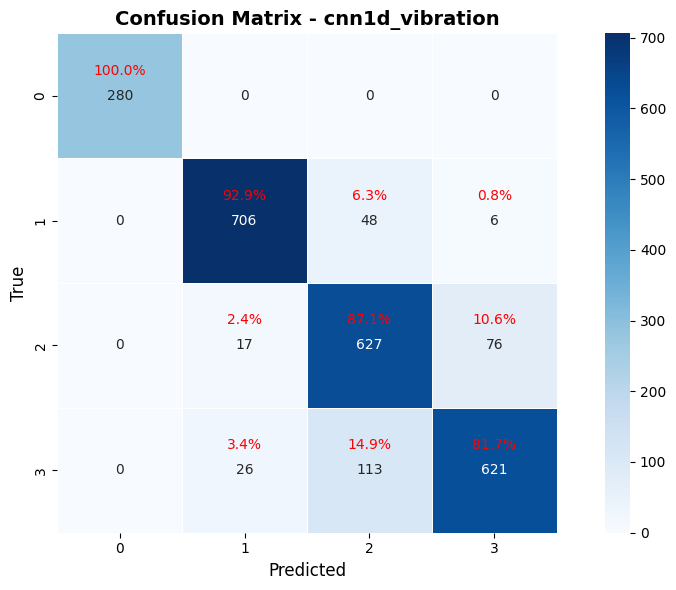


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.8865
Total de Amostras: 2520


In [2]:
from src.experiments.features_1d import ExperimentResults
import pandas as pd

# read the json from multiround experiment


loaded_results = ExperimentResults.load_json(f"/home/vbbonella/mestrado/tese-mestrado/experiments_notebooks/results_torch/vibration_analysis_results_cnn1d_vibration_20251007_150941/torch_results_20251007_150941.json")

loaded_results.show_results()